# 📒 Scanner ID Pipeline with Flatfield Fingerprints
This notebook extracts **scanner fingerprints** from flat-field images, then compares document noise patterns against them using correlation, FFT features, and trains ML models (SVM/CNN).

In [1]:
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable


In [2]:
# 🔍 Scanner ID Pipeline with Flatfield Fingerprints - WINDOWS FIXED VERSION
# This notebook extracts scanner fingerprints from flat-field images, then compares 
# document noise patterns against them using correlation, FFT features, and trains ML models (SVM/CNN).

import os
import glob
import random
import warnings
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple, Optional, Union
from collections import Counter
import logging

# Image processing
from skimage import io, color
from skimage.util import img_as_float32
from skimage.restoration import denoise_wavelet

# FFT
from numpy.fft import fft2, fftshift

# Machine Learning
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import joblib

# Deep Learning
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models

# XGBoost
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("Warning: XGBoost not available. Install with: pip install xgboost")

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore', category=UserWarning)

# ==== CONFIGURATION ====
class Config:
    """Configuration class for the pipeline"""
    # EDIT THESE PATHS FOR YOUR MACHINE
    FLATROOT = r"D:\Ai Trace Finder\Ai trace finder\data\flatfields"
    OFFICIALROOT = r"D:\Ai Trace Finder\Ai trace finder\data\Official"
    WIKIROOT = r"D:\Ai Trace Finder\Ai trace finder\data\Wikipedia"
    ARTIFACTS_DIR = "artifacts"
    
    # Processing parameters
    MAX_DOCS_PER_SCANNER = None  # None for all documents
    PATCH_SIZE = 128
    PATCH_STRIDE = 256
    MIN_MARGIN = 16
    FFT_BINS = 16
    
    # ML parameters
    TEST_SIZE = 0.25
    RANDOM_STATE = 42
    CNN_EPOCHS = 15  # Increased from 10
    CNN_BATCH_SIZE = 64
    CNN_LEARNING_RATE = 1e-4
    
    # Memory management
    MAX_PATCHES_IN_MEMORY = 10000  # Limit patches to prevent memory issues

config = Config()

def check_paths():
    """Check if all required paths exist"""
    paths = {
        "Flatfields": config.FLATROOT,
        "Official Documents": config.OFFICIALROOT, 
        "Wikipedia Documents": config.WIKIROOT
    }
    
    logger.info("Checking paths...")
    all_exist = True
    for name, path in paths.items():
        exists = os.path.exists(path)
        status = "✓ OK" if exists else "✗ MISSING"
        logger.info(f"{name}: {path} => {status}")
        if not exists:
            all_exist = False
    
    if not all_exist:
        raise FileNotFoundError("Some required paths are missing. Please update Config class.")
    
    # Create artifacts directory
    Path(config.ARTIFACTS_DIR).mkdir(exist_ok=True)
    logger.info(f"Artifacts directory: {config.ARTIFACTS_DIR}")

# ==== IMAGE PROCESSING FUNCTIONS ====
def load_image_gray(path: str) -> Optional[np.ndarray]:
    """Load and convert image to grayscale with error handling"""
    try:
        if not os.path.exists(path):
            logger.warning(f"File not found: {path}")
            return None
            
        img = io.imread(path)
        
        # Handle different image formats
        if img.ndim == 3:
            if img.shape[-1] == 4:  # RGBA
                img = img[..., :3]  # Remove alpha channel
            img = color.rgb2gray(img)
        elif img.ndim == 2:
            # Already grayscale
            if np.issubdtype(img.dtype, np.integer):
                img = img.astype(np.float32) / np.iinfo(img.dtype).max
            else:
                img = img.astype(np.float32)
        else:
            logger.warning(f"Unexpected image dimensions: {img.shape} for {path}")
            return None
            
        return img_as_float32(img)
        
    except Exception as e:
        logger.error(f"Failed to load image {path}: {str(e)}")
        return None

def normalize_image(img: np.ndarray) -> np.ndarray:
    """Normalize image to zero mean and unit variance"""
    if img is None:
        return None
    mean_val = np.mean(img)
    std_val = np.std(img)
    if std_val < 1e-8:
        logger.warning("Image has very low variance, normalization might be unstable")
        std_val = 1e-8
    return (img - mean_val) / std_val

def residual_wavelet(img: np.ndarray) -> Optional[np.ndarray]:
    """Extract wavelet residual with error handling"""
    try:
        if img is None:
            return None
        denoised = denoise_wavelet(img, method='BayesShrink', mode='soft', rescale_sigma=True)
        residual = img - denoised
        return residual.astype(np.float32)
    except Exception as e:
        logger.error(f"Wavelet denoising failed: {str(e)}")
        return None

# ==== FILE DISCOVERY FUNCTIONS ====
def list_images(root: str, extensions=('.png', '.jpg', '.jpeg', '.tif', '.tiff', '.bmp')) -> List[str]:
    """List all image files recursively with better error handling"""
    if not os.path.exists(root):
        logger.warning(f"Directory does not exist: {root}")
        return []
        
    files = []
    try:
        for ext in extensions:
            # Case insensitive search
            pattern = os.path.join(root, '**', f'*{ext}')
            files.extend(glob.glob(pattern, recursive=True))
            # Also search uppercase
            pattern_upper = os.path.join(root, '**', f'*{ext.upper()}')
            files.extend(glob.glob(pattern_upper, recursive=True))
        
        # Remove duplicates and sort
        files = sorted(list(set(files)))
        logger.info(f"Found {len(files)} image files in {root}")
        return files
        
    except Exception as e:
        logger.error(f"Error listing images in {root}: {str(e)}")
        return []

def group_by_scanner(root: str) -> Dict[str, List[str]]:
    """Group image paths by scanner (first directory level)"""
    paths = list_images(root)
    mapping = {}
    
    for path in paths:
        try:
            rel_path = os.path.relpath(path, root)
            scanner_name = rel_path.split(os.sep)[0]
            mapping.setdefault(scanner_name, []).append(path)
        except Exception as e:
            logger.warning(f"Could not process path {path}: {str(e)}")
            continue
    
    # Log scanner distribution
    for scanner, files in mapping.items():
        logger.info(f"Scanner '{scanner}': {len(files)} files")
    
    return mapping

# ==== FINGERPRINT BUILDING ====
def build_scanner_fingerprints(flatroot: str) -> Dict[str, np.ndarray]:
    """Build scanner fingerprints from flatfield images with improved error handling"""
    by_scanner = group_by_scanner(flatroot)
    fingerprints = {}
    
    for scanner_name, paths in by_scanner.items():
        logger.info(f"Processing scanner: {scanner_name}")
        residuals = []
        failed_count = 0
        
        for path in paths:
            img = load_image_gray(path)
            if img is None:
                failed_count += 1
                continue
                
            img_norm = normalize_image(img)
            if img_norm is None:
                failed_count += 1
                continue
                
            residual = residual_wavelet(img_norm)
            if residual is None:
                failed_count += 1
                continue
                
            residuals.append(residual)
        
        if residuals:
            # Ensure all residuals have the same shape
            shapes = [r.shape for r in residuals]
            if len(set(shapes)) > 1:
                logger.warning(f"Scanner {scanner_name} has images with different shapes: {set(shapes)}")
                # Find most common shape
                common_shape = Counter(shapes).most_common(1)[0][0]
                residuals = [r for r in residuals if r.shape == common_shape]
                logger.info(f"Using {len(residuals)} images with shape {common_shape}")
            
            if residuals:
                fingerprint = np.mean(residuals, axis=0).astype(np.float32)
                fingerprints[scanner_name] = fingerprint
                logger.info(f"Built fingerprint for {scanner_name} using {len(residuals)} images")
                if failed_count > 0:
                    logger.warning(f"Failed to process {failed_count} images for {scanner_name}")
            else:
                logger.error(f"No valid residuals for scanner {scanner_name}")
        else:
            logger.error(f"No flatfield images found for scanner {scanner_name}")
    
    return fingerprints

# ==== FEATURE EXTRACTION ====
def correlation_coefficient(a: np.ndarray, b: np.ndarray) -> float:
    """Compute normalized correlation coefficient with numerical stability"""
    try:
        a_centered = a - np.mean(a)
        b_centered = b - np.mean(b)
        
        numerator = np.sum(a_centered * b_centered)
        denominator = np.sqrt(np.sum(a_centered**2)) * np.sqrt(np.sum(b_centered**2))
        
        if denominator < 1e-10:
            return 0.0
        
        return float(numerator / denominator)
    except:
        return 0.0

def correlation_features(residual: np.ndarray, fingerprints: Dict[str, np.ndarray], 
                        label_names: List[str]) -> np.ndarray:
    """Compute correlation features with all scanner fingerprints"""
    features = []
    for label in label_names:
        if label in fingerprints:
            # Ensure shapes match
            if residual.shape != fingerprints[label].shape:
                # Resize to minimum common shape
                min_h = min(residual.shape[0], fingerprints[label].shape[0])
                min_w = min(residual.shape[1], fingerprints[label].shape[1])
                res_crop = residual[:min_h, :min_w]
                fp_crop = fingerprints[label][:min_h, :min_w]
                corr = correlation_coefficient(res_crop, fp_crop)
            else:
                corr = correlation_coefficient(residual, fingerprints[label])
            features.append(corr)
        else:
            features.append(0.0)
    
    return np.array(features, dtype=np.float32)

def fft_radial_stats(patch: np.ndarray, n_bins: int = None) -> np.ndarray:
    """Compute radial FFT statistics with improved numerical stability"""
    if n_bins is None:
        n_bins = config.FFT_BINS
        
    try:
        # Apply window to reduce spectral leakage
        window = np.outer(np.hanning(patch.shape[0]), np.hanning(patch.shape[1]))
        windowed_patch = patch * window
        
        F = fftshift(fft2(windowed_patch))
        power_spectrum = np.abs(F) ** 2
        
        H, W = power_spectrum.shape
        center_y, center_x = H // 2, W // 2
        
        y, x = np.indices(power_spectrum.shape)
        radius = np.sqrt((y - center_y)**2 + (x - center_x)**2)
        max_radius = np.sqrt(center_y**2 + center_x**2)
        
        if max_radius < 1e-6:
            return np.zeros(n_bins, dtype=np.float32)
        
        radius_normalized = radius / max_radius
        bins = np.linspace(0, 1.0, n_bins + 1)
        
        features = []
        for i in range(n_bins):
            mask = (radius_normalized >= bins[i]) & (radius_normalized < bins[i + 1])
            if np.any(mask):
                mean_power = np.mean(power_spectrum[mask])
                features.append(np.log1p(mean_power))  # log(1 + x) for numerical stability
            else:
                features.append(0.0)
        
        features = np.array(features, dtype=np.float32)
        
        # Normalize features
        mean_feat = np.mean(features)
        std_feat = np.std(features)
        if std_feat > 1e-8:
            features = (features - mean_feat) / std_feat
        
        return features
        
    except Exception as e:
        logger.warning(f"FFT feature extraction failed: {str(e)}")
        return np.zeros(n_bins, dtype=np.float32)

# ==== DATASET BUILDING ====
def build_document_dataset(docroot: str, fingerprints: Dict[str, np.ndarray], 
                          max_docs: Optional[int] = None) -> Tuple[np.ndarray, np.ndarray, List[str]]:
    """Build dataset from document images with memory management"""
    by_scanner = group_by_scanner(docroot)
    label_names = sorted(fingerprints.keys())
    
    # Filter to only scanners that have fingerprints
    by_scanner = {k: v for k, v in by_scanner.items() if k in fingerprints}
    
    if not by_scanner:
        logger.error("No scanners found with matching fingerprints!")
        return np.array([]), np.array([]), []
    
    X_list, y_list = [], []
    total_processed = 0
    
    for scanner_name in by_scanner.keys():
        files_to_process = by_scanner[scanner_name][:max_docs] if max_docs else by_scanner[scanner_name]
        
        logger.info(f"Processing {len(files_to_process)} documents for scanner {scanner_name}")
        
        for i, path in enumerate(files_to_process):
            if i % 50 == 0:  # Progress logging
                logger.info(f"  Progress: {i}/{len(files_to_process)}")
            
            img = load_image_gray(path)
            if img is None:
                continue
                
            img_norm = normalize_image(img)
            if img_norm is None:
                continue
                
            residual = residual_wavelet(img_norm)
            if residual is None:
                continue
            
            # Extract features
            corr_feats = correlation_features(residual, fingerprints, label_names)
            fft_feats = fft_radial_stats(residual)
            
            # Combine features
            combined_features = np.concatenate([corr_feats, fft_feats])
            
            X_list.append(combined_features)
            y_list.append(label_names.index(scanner_name))
            total_processed += 1
    
    if not X_list:
        logger.error("No valid features extracted!")
        return np.array([]), np.array([]), []
    
    X = np.array(X_list, dtype=np.float32)
    y = np.array(y_list, dtype=np.int64)
    
    logger.info(f"Dataset built: {X.shape[0]} samples, {X.shape[1]} features, {len(label_names)} classes")
    return X, y, label_names

# ==== MACHINE LEARNING MODELS ====
def create_svm_pipeline(C: float = 10.0, gamma: Union[str, float] = 'scale') -> Pipeline:
    """Create SVM pipeline with preprocessing"""
    return Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(C=C, kernel='rbf', gamma=gamma, probability=True, 
                   class_weight='balanced', random_state=config.RANDOM_STATE))
    ])

def train_and_evaluate_model(X: np.ndarray, y: np.ndarray, labels: List[str], 
                           model_name: str, model, test_size: float = None) -> object:
    """Generic function to train and evaluate models with cross-validation"""
    if test_size is None:
        test_size = config.TEST_SIZE
    
    logger.info(f"Training {model_name}...")
    
    # Stratified split to ensure balanced classes
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=config.RANDOM_STATE
    )
    
    # Train model
    model.fit(X_train, y_train)
    
    # Evaluate
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    logger.info(f"{model_name} Test Accuracy: {accuracy:.4f}")
    print(f"\n=== {model_name} Results ===")
    print(f"Test Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=labels))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    ConfusionMatrixDisplay(cm, display_labels=labels).plot(xticks_rotation=45)
    plt.title(f"{model_name} Confusion Matrix")
    plt.tight_layout()
    plt.show()
    
    return model

def train_random_forest(X: np.ndarray, y: np.ndarray, labels: List[str]) -> RandomForestClassifier:
    """Train Random Forest classifier"""
    model = RandomForestClassifier(
        n_estimators=200, 
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=config.RANDOM_STATE, 
        class_weight='balanced',
        n_jobs=-1
    )
    return train_and_evaluate_model(X, y, labels, "Random Forest", model)

def train_xgboost(X: np.ndarray, y: np.ndarray, labels: List[str]) -> object:
    """Train XGBoost classifier if available"""
    if not XGBOOST_AVAILABLE:
        logger.warning("XGBoost not available, skipping...")
        return None
    
    model = xgb.XGBClassifier(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='multi:softmax',
        num_class=len(labels),
        random_state=config.RANDOM_STATE,
        n_jobs=-1
    )
    return train_and_evaluate_model(X, y, labels, "XGBoost", model)

# ==== DEEP LEARNING COMPONENTS ====
class PatchDataset(Dataset):
    """Dataset class for CNN training with patches"""
    def __init__(self, patches: np.ndarray, labels: np.ndarray):
        self.patches = patches.astype(np.float32)
        self.labels = labels.astype(np.int64)
        
    def __len__(self) -> int:
        return len(self.patches)
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        # Add channel dimension for grayscale
        patch = torch.from_numpy(self.patches[idx][None, ...])  # Shape: (1, H, W)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return patch, label

class ResNetScanner(nn.Module):
    """ResNet18 modified for grayscale scanner identification"""
    def __init__(self, n_classes: int):
        super().__init__()
        self.resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        
        # Modify first conv layer for grayscale input
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # Modify final layer
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(in_features, n_classes)
        
        # Add dropout for regularization
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        features = self.resnet.avgpool(self.resnet.layer4(
            self.resnet.layer3(
                self.resnet.layer2(
                    self.resnet.layer1(
                        self.resnet.relu(
                            self.resnet.bn1(
                                self.resnet.conv1(x)
                            )
                        )
                    )
                )
            )
        ))
        features = torch.flatten(features, 1)
        features = self.dropout(features)
        return self.resnet.fc(features)

def extract_patches_from_image(img: np.ndarray, patch_size: int = None, 
                              stride: int = None, min_margin: int = None) -> np.ndarray:
    """Extract patches from image with memory-efficient approach"""
    if patch_size is None:
        patch_size = config.PATCH_SIZE
    if stride is None:
        stride = config.PATCH_STRIDE
    if min_margin is None:
        min_margin = config.MIN_MARGIN
    
    H, W = img.shape
    patches = []
    
    # Calculate number of patches to avoid memory issues
    max_patches_per_image = config.MAX_PATCHES_IN_MEMORY // 100  # Conservative estimate
    
    y_positions = list(range(min_margin, H - patch_size - min_margin + 1, stride))
    x_positions = list(range(min_margin, W - patch_size - min_margin + 1, stride))
    
    # Limit number of patches if too many
    total_possible = len(y_positions) * len(x_positions)
    if total_possible > max_patches_per_image:
        # Randomly sample positions
        random.seed(config.RANDOM_STATE)
        n_y = min(len(y_positions), int(np.sqrt(max_patches_per_image)))
        n_x = min(len(x_positions), max_patches_per_image // n_y)
        
        y_positions = sorted(random.sample(y_positions, n_y))
        x_positions = sorted(random.sample(x_positions, n_x))
    
    for y in y_positions:
        for x in x_positions:
            patch = img[y:y+patch_size, x:x+patch_size]
            if patch.shape == (patch_size, patch_size):  # Ensure full patch size
                patches.append(patch)
    
    return np.stack(patches) if patches else np.empty((0, patch_size, patch_size), dtype=img.dtype)

def build_patch_dataset_memory_efficient(docroot: str, max_docs: Optional[int] = None) -> Tuple[np.ndarray, np.ndarray, List[str]]:
    """Build patch dataset with memory management"""
    by_scanner = group_by_scanner(docroot)
    labels = sorted(by_scanner.keys())
    
    all_patches = []
    all_labels = []
    patch_count = 0
    
    for scanner_idx, scanner_name in enumerate(labels):
        files = by_scanner[scanner_name][:max_docs] if max_docs else by_scanner[scanner_name]
        logger.info(f"Extracting patches from {len(files)} documents for scanner {scanner_name}")
        
        for i, path in enumerate(files):
            if patch_count >= config.MAX_PATCHES_IN_MEMORY:
                logger.warning(f"Reached maximum patch limit ({config.MAX_PATCHES_IN_MEMORY}), stopping...")
                break
                
            img = load_image_gray(path)
            if img is None:
                continue
                
            img_norm = normalize_image(img)
            if img_norm is None:
                continue
                
            residual = residual_wavelet(img_norm)
            if residual is None:
                continue
            
            patches = extract_patches_from_image(residual)
            
            if len(patches) > 0:
                # Limit patches per image to prevent memory issues
                max_patches_per_img = min(len(patches), 50)
                if len(patches) > max_patches_per_img:
                    indices = np.random.choice(len(patches), max_patches_per_img, replace=False)
                    patches = patches[indices]
                
                all_patches.append(patches)
                all_labels.extend([scanner_idx] * len(patches))
                patch_count += len(patches)
            
            if i % 10 == 0:
                logger.info(f"  Processed {i+1}/{len(files)} files, {patch_count} patches so far")
        
        if patch_count >= config.MAX_PATCHES_IN_MEMORY:
            break
    
    if not all_patches:
        logger.error("No patches extracted!")
        return np.array([]), np.array([]), []
    
    # Concatenate all patches
    X_patches = np.concatenate(all_patches, axis=0)
    y_patches = np.array(all_labels, dtype=np.int64)
    
    logger.info(f"Patch dataset: {X_patches.shape} patches from {len(labels)} scanners")
    return X_patches, y_patches, labels

def train_cnn_model(patches: np.ndarray, labels: np.ndarray, n_classes: int, 
                   epochs: int = None, batch_size: int = None, lr: float = None) -> ResNetScanner:
    """Train CNN model with improved training loop - WINDOWS COMPATIBLE"""
    if epochs is None:
        epochs = config.CNN_EPOCHS
    if batch_size is None:
        batch_size = config.CNN_BATCH_SIZE
    if lr is None:
        lr = config.CNN_LEARNING_RATE
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    logger.info(f"Training CNN on device: {device}")
    
    # Create dataset and split
    dataset = PatchDataset(patches, labels)
    
    # Stratified split for better validation
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    
    train_dataset, val_dataset = torch.utils.data.random_split(
        dataset, [train_size, val_size], 
        generator=torch.Generator().manual_seed(config.RANDOM_STATE)
    )
    
    # WINDOWS FIX: Set num_workers=0 to avoid multiprocessing issues on Windows
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    # Initialize model
    model = ResNetScanner(n_classes).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
    
    # Training loop
    best_val_acc = 0.0
    train_losses = []
    val_accuracies = []
    
    for epoch in range(epochs):
        # Training
        model.train()
        epoch_loss = 0.0
        num_batches = 0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            num_batches += 1
        
        avg_train_loss = epoch_loss / num_batches
        train_losses.append(avg_train_loss)
        
        # Validation
        model.eval()
        correct = 0
        total = 0
        
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                pred = output.argmax(dim=1)
                correct += pred.eq(target).sum().item()
                total += target.size(0)
        
        val_acc = correct / total
        val_accuracies.append(val_acc)
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
            }, os.path.join(config.ARTIFACTS_DIR, 'best_cnn_model.pt'))
        
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']
        
        logger.info(f"Epoch {epoch+1}/{epochs}: "
                   f"Train Loss: {avg_train_loss:.4f}, "
                   f"Val Acc: {val_acc:.4f}, "
                   f"LR: {current_lr:.6f}")
    
    # Plot training curves
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies)
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    
    plt.tight_layout()
    plt.savefig(os.path.join(config.ARTIFACTS_DIR, 'training_curves.png'))
    plt.show()
    
    logger.info(f"Best validation accuracy: {best_val_acc:.4f}")
    return model

def evaluate_cnn_final(model: ResNetScanner, patches: np.ndarray, labels: np.ndarray, 
                      label_names: List[str]) -> float:
    """Final evaluation of CNN model - WINDOWS COMPATIBLE"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    
    dataset = PatchDataset(patches, labels)
    # WINDOWS FIX: Set num_workers=0
    dataloader = DataLoader(dataset, batch_size=config.CNN_BATCH_SIZE, shuffle=False, num_workers=0)
    
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for data, target in dataloader:
            data = data.to(device)
            output = model(data)
            pred = output.argmax(dim=1).cpu().numpy()
            all_preds.extend(pred)
            all_targets.extend(target.numpy())
    
    accuracy = accuracy_score(all_targets, all_preds)
    
    print(f"\n=== Final CNN Evaluation ===")
    print(f"Overall Patch Accuracy: {accuracy:.4f}")
    print("\nDetailed Classification Report:")
    print(classification_report(all_targets, all_preds, target_names=label_names))
    
    # Confusion Matrix
    cm = confusion_matrix(all_targets, all_preds)
    plt.figure(figsize=(10, 8))
    ConfusionMatrixDisplay(cm, display_labels=label_names).plot(xticks_rotation=45)
    plt.title('CNN Final Confusion Matrix')
    plt.tight_layout()
    plt.savefig(os.path.join(config.ARTIFACTS_DIR, 'cnn_confusion_matrix.png'))
    plt.show()
    
    return accuracy

# ==== SAVE/LOAD FUNCTIONS ====
def save_models_and_data(models_dict: Dict, fingerprints: Dict, labels: List[str]):
    """Save all trained models and metadata"""
    # Save traditional ML models
    for model_name, model in models_dict.items():
        if model is not None:
            filename = os.path.join(config.ARTIFACTS_DIR, f"{model_name.lower().replace(' ', '_')}.joblib")
            joblib.dump({'model': model, 'labels': labels}, filename)
            logger.info(f"Saved {model_name} to {filename}")
    
    # Save fingerprints and metadata
    metadata = {
        'fingerprints': fingerprints,
        'labels': labels,
        'config': {
            'patch_size': config.PATCH_SIZE,
            'patch_stride': config.PATCH_STRIDE,
            'fft_bins': config.FFT_BINS,
            'random_state': config.RANDOM_STATE
        }
    }
    
    metadata_file = os.path.join(config.ARTIFACTS_DIR, 'metadata.joblib')
    joblib.dump(metadata, metadata_file)
    logger.info(f"Saved metadata to {metadata_file}")

def load_model(model_path: str):
    """Load a saved model"""
    try:
        data = joblib.load(model_path)
        return data['model'], data['labels']
    except Exception as e:
        logger.error(f"Failed to load model from {model_path}: {str(e)}")
        return None, None

# ==== MAIN PIPELINE EXECUTION ====
def run_complete_pipeline():
    """Run the complete scanner identification pipeline"""
    print("Scanner Identification Pipeline")
    print("=" * 50)
    
    try:
        # Step 1: Check paths
        check_paths()
        
        # Step 2: Build scanner fingerprints
        print("\nStep 1: Building Scanner Fingerprints")
        fingerprints = build_scanner_fingerprints(config.FLATROOT)
        
        if not fingerprints:
            logger.error("No fingerprints could be built. Check your flatfield data.")
            return
        
        print(f"Built fingerprints for {len(fingerprints)} scanners")
        
        # Step 3: Build feature-based dataset
        print("\nStep 2: Building Feature Dataset")
        print("Processing Official documents...")
        X_official, y_official, labels = build_document_dataset(
            config.OFFICIALROOT, fingerprints, config.MAX_DOCS_PER_SCANNER
        )
        
        print("Processing Wikipedia documents...")
        X_wiki, y_wiki, _ = build_document_dataset(
            config.WIKIROOT, fingerprints, config.MAX_DOCS_PER_SCANNER
        )
        
        if len(X_official) == 0 and len(X_wiki) == 0:
            logger.error("No feature data could be built. Check your document data.")
            return
        
        # Combine datasets
        X_combined = np.concatenate([X_official, X_wiki], axis=0) if len(X_official) > 0 and len(X_wiki) > 0 else (X_official if len(X_official) > 0 else X_wiki)
        y_combined = np.concatenate([y_official, y_wiki], axis=0) if len(y_official) > 0 and len(y_wiki) > 0 else (y_official if len(y_official) > 0 else y_wiki)
        
        print(f"Combined dataset: {X_combined.shape[0]} samples, {len(labels)} classes")
        
        # Step 4: Train traditional ML models
        print("\nStep 3: Training Traditional ML Models")
        models = {}
        
        # SVM
        svm_model = create_svm_pipeline()
        models['SVM'] = train_and_evaluate_model(X_combined, y_combined, labels, "SVM", svm_model)
        
        # Random Forest
        models['Random Forest'] = train_random_forest(X_combined, y_combined, labels)
        
        # XGBoost (if available)
        if XGBOOST_AVAILABLE:
            models['XGBoost'] = train_xgboost(X_combined, y_combined, labels)
        
        # Step 5: Build patch dataset for CNN
        print("\nStep 4: Building Patch Dataset for CNN")
        print("Processing Official documents for patches...")
        X_patches_off, y_patches_off, patch_labels = build_patch_dataset_memory_efficient(
            config.OFFICIALROOT, config.MAX_DOCS_PER_SCANNER
        )
        
        print("Processing Wikipedia documents for patches...")
        X_patches_wiki, y_patches_wiki, _ = build_patch_dataset_memory_efficient(
            config.WIKIROOT, config.MAX_DOCS_PER_SCANNER
        )
        
        if len(X_patches_off) == 0 and len(X_patches_wiki) == 0:
            logger.warning("No patch data could be built. Skipping CNN training.")
            cnn_model = None
        else:
            # Combine patch datasets
            X_patches = np.concatenate([X_patches_off, X_patches_wiki], axis=0) if len(X_patches_off) > 0 and len(X_patches_wiki) > 0 else (X_patches_off if len(X_patches_off) > 0 else X_patches_wiki)
            y_patches = np.concatenate([y_patches_off, y_patches_wiki], axis=0) if len(y_patches_off) > 0 and len(y_patches_wiki) > 0 else (y_patches_off if len(y_patches_off) > 0 else y_patches_wiki)
            
            print(f"Patch dataset: {X_patches.shape[0]} patches")
            
            # Step 6: Train CNN
            print("\nStep 5: Training CNN (ResNet18)")
            cnn_model = train_cnn_model(X_patches, y_patches, len(labels))
            
            # Final CNN evaluation
            evaluate_cnn_final(cnn_model, X_patches, y_patches, labels)
        
        # Step 7: Save everything
        print("\nStep 6: Saving Models and Results")
        save_models_and_data(models, fingerprints, labels)
        
        if cnn_model is not None:
            # CNN model is already saved during training (best model)
            logger.info("CNN model saved as best_cnn_model.pt")
        
        print("\nPipeline completed successfully!")
        print(f"All artifacts saved in: {config.ARTIFACTS_DIR}/")
        print("\nSummary:")
        print(f"  - Scanner fingerprints: {len(fingerprints)} scanners")
        print(f"  - Feature dataset: {X_combined.shape[0] if 'X_combined' in locals() else 0} samples")
        print(f"  - Patch dataset: {X_patches.shape[0] if 'X_patches' in locals() else 0} patches")
        print(f"  - Trained models: {len([m for m in models.values() if m is not None]) + (1 if cnn_model else 0)}")
        
    except Exception as e:
        logger.error(f"Pipeline failed: {str(e)}")
        raise

# ==== INFERENCE FUNCTIONS ====
def predict_document_scanner(image_path: str, model_path: str, fingerprints_path: str) -> Dict:
    """Predict scanner for a single document"""
    try:
        # Load model and metadata
        model, labels = load_model(model_path)
        metadata = joblib.load(fingerprints_path)
        fingerprints = metadata['fingerprints']
        
        if model is None:
            return {"error": "Failed to load model"}
        
        # Process image
        img = load_image_gray(image_path)
        if img is None:
            return {"error": "Failed to load image"}
        
        img_norm = normalize_image(img)
        residual = residual_wavelet(img_norm)
        
        # Extract features
        corr_feats = correlation_features(residual, fingerprints, labels)
        fft_feats = fft_radial_stats(residual)
        features = np.concatenate([corr_feats, fft_feats]).reshape(1, -1)
        
        # Predict
        prediction = model.predict(features)[0]
        probabilities = model.predict_proba(features)[0] if hasattr(model, 'predict_proba') else None
        
        result = {
            "predicted_scanner": labels[prediction],
            "confidence": float(probabilities[prediction]) if probabilities is not None else None,
            "all_probabilities": {labels[i]: float(prob) for i, prob in enumerate(probabilities)} if probabilities is not None else None
        }
        
        return result
        
    except Exception as e:
        return {"error": str(e)}

def batch_predict_documents(image_folder: str, model_path: str, fingerprints_path: str) -> List[Dict]:
    """Predict scanner for multiple documents"""
    image_paths = list_images(image_folder)
    results = []
    
    for img_path in image_paths:
        result = predict_document_scanner(img_path, model_path, fingerprints_path)
        result['image_path'] = img_path
        results.append(result)
        
        if len(results) % 10 == 0:
            logger.info(f"Processed {len(results)}/{len(image_paths)} images")
    
    return results

# ==== JUPYTER NOTEBOOK EXECUTION ====
if __name__ == "__main__" or "__file__" not in globals():
    # This section runs when executed in Jupyter notebook
    print("Scanner Identification Pipeline - Windows Fixed Version")
    print("=" * 60)
    print()
    print("KEY FIX: Set num_workers=0 in DataLoader to avoid Windows multiprocessing issues")
    print()
    print("To run the complete pipeline, execute:")
    print(">>> run_complete_pipeline()")
    print()
    print("To predict a single document:")
    print(">>> result = predict_document_scanner('path/to/image.jpg', 'artifacts/svm.joblib', 'artifacts/metadata.joblib')")
    print()
    print("To run batch predictions:")
    print(">>> results = batch_predict_documents('path/to/images/', 'artifacts/svm.joblib', 'artifacts/metadata.joblib')")
    print()
    print("Configuration can be modified in the Config class above.")
    print("Current settings:")
    print(f"  - Max documents per scanner: {config.MAX_DOCS_PER_SCANNER}")
    print(f"  - Patch size: {config.PATCH_SIZE}")
    print(f"  - CNN epochs: {config.CNN_EPOCHS}")
    print(f"  - Max patches in memory: {config.MAX_PATCHES_IN_MEMORY}")

# Uncomment the line below to run the pipeline automatically
# run_complete_pipeline()

Scanner Identification Pipeline - Windows Fixed Version

KEY FIX: Set num_workers=0 in DataLoader to avoid Windows multiprocessing issues

To run the complete pipeline, execute:
>>> run_complete_pipeline()

To predict a single document:
>>> result = predict_document_scanner('path/to/image.jpg', 'artifacts/svm.joblib', 'artifacts/metadata.joblib')

To run batch predictions:
>>> results = batch_predict_documents('path/to/images/', 'artifacts/svm.joblib', 'artifacts/metadata.joblib')

Configuration can be modified in the Config class above.
Current settings:
  - Max documents per scanner: None
  - Patch size: 128
  - CNN epochs: 15
  - Max patches in memory: 10000


2025-09-25 21:53:10,321 - INFO - Checking paths...
2025-09-25 21:53:10,323 - INFO - Flatfields: D:\Ai Trace Finder\Ai trace finder\data\flatfields => ✓ OK
2025-09-25 21:53:10,323 - INFO - Official Documents: D:\Ai Trace Finder\Ai trace finder\data\Official => ✓ OK
2025-09-25 21:53:10,323 - INFO - Wikipedia Documents: D:\Ai Trace Finder\Ai trace finder\data\Wikipedia => ✓ OK
2025-09-25 21:53:10,326 - INFO - Artifacts directory: artifacts
2025-09-25 21:53:10,338 - INFO - Found 22 image files in D:\Ai Trace Finder\Ai trace finder\data\flatfields
2025-09-25 21:53:10,338 - INFO - Scanner 'Canon120-1': 2 files
2025-09-25 21:53:10,338 - INFO - Scanner 'Canon120-2': 2 files
2025-09-25 21:53:10,338 - INFO - Scanner 'Canon220': 2 files
2025-09-25 21:53:10,338 - INFO - Scanner 'Canon9000-1': 2 files
2025-09-25 21:53:10,338 - INFO - Scanner 'Canon9000-2': 2 files
2025-09-25 21:53:10,343 - INFO - Scanner 'EpsonV370-1': 2 files
2025-09-25 21:53:10,344 - INFO - Scanner 'EpsonV370-2': 2 files
2025-09-

Scanner Identification Pipeline

Step 1: Building Scanner Fingerprints


2025-09-25 21:53:11,937 - WARNING - Scanner Canon120-1 has images with different shapes: {(1752, 1240), (3508, 2480)}
2025-09-25 21:53:11,937 - INFO - Using 1 images with shape (1752, 1240)
2025-09-25 21:53:11,951 - INFO - Built fingerprint for Canon120-1 using 1 images
2025-09-25 21:53:11,951 - INFO - Processing scanner: Canon120-2
2025-09-25 21:53:13,857 - INFO - Built fingerprint for Canon120-2 using 2 images
2025-09-25 21:53:13,858 - INFO - Processing scanner: Canon220
2025-09-25 21:53:14,967 - WARNING - Scanner Canon220 has images with different shapes: {(1752, 1240), (3508, 2480)}
2025-09-25 21:53:14,967 - INFO - Using 1 images with shape (1752, 1240)
2025-09-25 21:53:14,982 - INFO - Built fingerprint for Canon220 using 1 images
2025-09-25 21:53:14,984 - INFO - Processing scanner: Canon9000-1
2025-09-25 21:53:15,840 - WARNING - Scanner Canon9000-1 has images with different shapes: {(1754, 1240), (3508, 2480)}
2025-09-25 21:53:15,840 - INFO - Using 1 images with shape (1754, 1240)

Built fingerprints for 11 scanners

Step 2: Building Feature Dataset
Processing Official documents...


2025-09-25 21:53:42,642 - INFO - Processing 16 documents for scanner Canon120-2
2025-09-25 21:53:42,643 - INFO -   Progress: 0/16
2025-09-25 21:54:01,899 - INFO - Processing 38 documents for scanner Canon220
2025-09-25 21:54:01,899 - INFO -   Progress: 0/38
2025-09-25 21:54:51,409 - INFO - Processing 16 documents for scanner Canon9000-1
2025-09-25 21:54:51,412 - INFO -   Progress: 0/16
2025-09-25 21:55:16,264 - INFO - Processing 20 documents for scanner Canon9000-2
2025-09-25 21:55:16,266 - INFO -   Progress: 0/20
2025-09-25 21:55:32,467 - INFO - Processing 45 documents for scanner EpsonV370-1
2025-09-25 21:55:32,467 - INFO -   Progress: 0/45
2025-09-25 21:56:37,511 - INFO - Processing 35 documents for scanner EpsonV370-2
2025-09-25 21:56:37,511 - INFO -   Progress: 0/35
2025-09-25 21:57:31,740 - INFO - Processing 26 documents for scanner EpsonV39-1
2025-09-25 21:57:31,742 - INFO -   Progress: 0/26
2025-09-25 21:57:54,052 - INFO - Processing 20 documents for scanner EpsonV39-2
2025-09-

Processing Wikipedia documents...


2025-09-25 21:59:57,305 - INFO - Processing 11 documents for scanner Canon120-2
2025-09-25 21:59:57,305 - INFO -   Progress: 0/11
2025-09-25 22:00:07,359 - INFO - Processing 11 documents for scanner Canon220
2025-09-25 22:00:07,359 - INFO -   Progress: 0/11
2025-09-25 22:00:19,945 - INFO - Processing 10 documents for scanner Canon9000-1
2025-09-25 22:00:19,945 - INFO -   Progress: 0/10
2025-09-25 22:00:33,318 - INFO - Processing 27 documents for scanner Canon9000-2
2025-09-25 22:00:33,318 - INFO -   Progress: 0/27
2025-09-25 22:01:00,521 - INFO - Processing 18 documents for scanner EpsonV370-1
2025-09-25 22:01:00,521 - INFO -   Progress: 0/18
2025-09-25 22:01:29,249 - INFO - Processing 48 documents for scanner EpsonV370-2
2025-09-25 22:01:29,249 - INFO -   Progress: 0/48
2025-09-25 22:02:52,734 - INFO - Processing 48 documents for scanner EpsonV39-1
2025-09-25 22:02:52,734 - INFO -   Progress: 0/48
2025-09-25 22:04:57,018 - INFO - Processing 8 documents for scanner EpsonV39-2
2025-09-2

Combined dataset: 493 samples, 11 classes

Step 3: Training Traditional ML Models

=== SVM Results ===
Test Accuracy: 0.6855

Classification Report:
              precision    recall  f1-score   support

  Canon120-1       0.60      0.50      0.55         6
  Canon120-2       0.27      0.43      0.33         7
    Canon220       0.62      0.67      0.64        12
 Canon9000-1       0.20      0.17      0.18         6
 Canon9000-2       0.67      0.67      0.67        12
 EpsonV370-1       0.59      0.81      0.68        16
 EpsonV370-2       0.80      0.57      0.67        21
  EpsonV39-1       0.94      0.84      0.89        19
  EpsonV39-2       0.57      0.57      0.57         7
   EpsonV550       1.00      0.83      0.91         6
          HP       1.00      1.00      1.00        12

    accuracy                           0.69       124
   macro avg       0.66      0.64      0.64       124
weighted avg       0.71      0.69      0.69       124



<Figure size 1000x800 with 0 Axes>

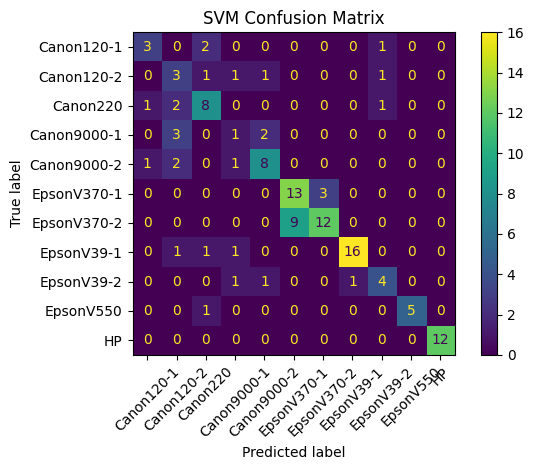

2025-09-25 22:05:20,103 - INFO - Training Random Forest...
2025-09-25 22:05:20,512 - INFO - Random Forest Test Accuracy: 0.7097



=== Random Forest Results ===
Test Accuracy: 0.7097

Classification Report:
              precision    recall  f1-score   support

  Canon120-1       1.00      0.67      0.80         6
  Canon120-2       0.43      0.43      0.43         7
    Canon220       0.75      0.75      0.75        12
 Canon9000-1       0.33      0.17      0.22         6
 Canon9000-2       0.64      0.58      0.61        12
 EpsonV370-1       0.57      0.75      0.65        16
 EpsonV370-2       0.80      0.57      0.67        21
  EpsonV39-1       0.86      0.95      0.90        19
  EpsonV39-2       0.42      0.71      0.53         7
   EpsonV550       0.83      0.83      0.83         6
          HP       1.00      1.00      1.00        12

    accuracy                           0.71       124
   macro avg       0.69      0.67      0.67       124
weighted avg       0.72      0.71      0.71       124



<Figure size 1000x800 with 0 Axes>

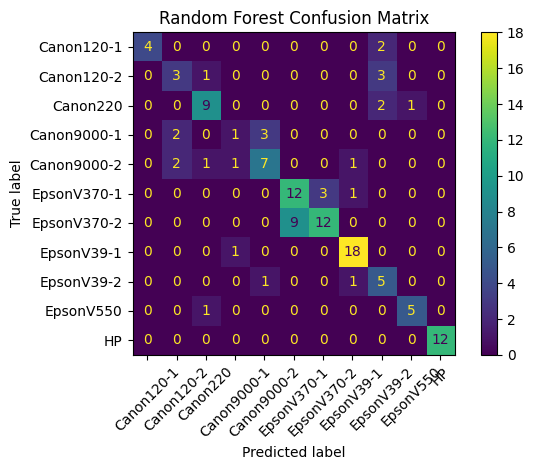

2025-09-25 22:05:20,784 - INFO - Training XGBoost...
2025-09-25 22:05:24,549 - INFO - XGBoost Test Accuracy: 0.7016



=== XGBoost Results ===
Test Accuracy: 0.7016

Classification Report:
              precision    recall  f1-score   support

  Canon120-1       0.67      0.33      0.44         6
  Canon120-2       0.22      0.29      0.25         7
    Canon220       0.62      0.67      0.64        12
 Canon9000-1       0.25      0.17      0.20         6
 Canon9000-2       0.62      0.67      0.64        12
 EpsonV370-1       0.71      0.75      0.73        16
 EpsonV370-2       0.80      0.76      0.78        21
  EpsonV39-1       0.89      0.89      0.89        19
  EpsonV39-2       0.50      0.57      0.53         7
   EpsonV550       0.83      0.83      0.83         6
          HP       1.00      1.00      1.00        12

    accuracy                           0.70       124
   macro avg       0.65      0.63      0.63       124
weighted avg       0.70      0.70      0.70       124



<Figure size 1000x800 with 0 Axes>

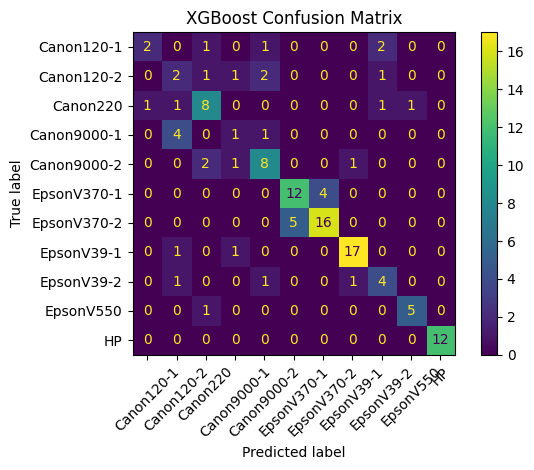

2025-09-25 22:05:24,887 - INFO - Found 288 image files in D:\Ai Trace Finder\Ai trace finder\data\Official
2025-09-25 22:05:24,891 - INFO - Scanner 'Canon120-1': 13 files
2025-09-25 22:05:24,891 - INFO - Scanner 'Canon120-2': 16 files
2025-09-25 22:05:24,891 - INFO - Scanner 'Canon220': 38 files
2025-09-25 22:05:24,893 - INFO - Scanner 'Canon9000-1': 16 files
2025-09-25 22:05:24,894 - INFO - Scanner 'Canon9000-2': 20 files
2025-09-25 22:05:24,894 - INFO - Scanner 'EpsonV370-1': 45 files
2025-09-25 22:05:24,894 - INFO - Scanner 'EpsonV370-2': 35 files
2025-09-25 22:05:24,894 - INFO - Scanner 'EpsonV39-1': 26 files
2025-09-25 22:05:24,894 - INFO - Scanner 'EpsonV39-2': 20 files
2025-09-25 22:05:24,894 - INFO - Scanner 'EpsonV550': 19 files
2025-09-25 22:05:24,894 - INFO - Scanner 'HP': 40 files
2025-09-25 22:05:24,898 - INFO - Extracting patches from 13 documents for scanner Canon120-1



Step 4: Building Patch Dataset for CNN
Processing Official documents for patches...


2025-09-25 22:05:25,078 - INFO -   Processed 1/13 files, 35 patches so far
2025-09-25 22:05:27,511 - INFO -   Processed 11/13 files, 400 patches so far
2025-09-25 22:05:29,292 - INFO - Extracting patches from 16 documents for scanner Canon120-2
2025-09-25 22:05:29,480 - INFO -   Processed 1/16 files, 535 patches so far
2025-09-25 22:05:31,201 - INFO -   Processed 11/16 files, 885 patches so far
2025-09-25 22:05:35,049 - INFO - Extracting patches from 38 documents for scanner Canon220
2025-09-25 22:05:35,231 - INFO -   Processed 1/38 files, 1155 patches so far
2025-09-25 22:05:37,129 - INFO -   Processed 11/38 files, 1505 patches so far
2025-09-25 22:05:38,960 - INFO -   Processed 21/38 files, 1855 patches so far
2025-09-25 22:05:44,654 - INFO -   Processed 31/38 files, 2280 patches so far
2025-09-25 22:05:50,883 - INFO - Extracting patches from 16 documents for scanner Canon9000-1
2025-09-25 22:05:51,089 - INFO -   Processed 1/16 files, 2665 patches so far
2025-09-25 22:05:54,049 - INF

Processing Wikipedia documents for patches...


2025-09-25 22:06:53,232 - INFO -   Processed 1/10 files, 35 patches so far
2025-09-25 22:06:55,757 - INFO - Extracting patches from 11 documents for scanner Canon120-2
2025-09-25 22:06:55,922 - INFO -   Processed 1/11 files, 415 patches so far
2025-09-25 22:06:58,180 - INFO -   Processed 11/11 files, 780 patches so far
2025-09-25 22:06:58,182 - INFO - Extracting patches from 11 documents for scanner Canon220
2025-09-25 22:06:58,352 - INFO -   Processed 1/11 files, 815 patches so far
2025-09-25 22:07:01,224 - INFO -   Processed 11/11 files, 1195 patches so far
2025-09-25 22:07:01,224 - INFO - Extracting patches from 10 documents for scanner Canon9000-1
2025-09-25 22:07:01,369 - INFO -   Processed 1/10 files, 1230 patches so far
2025-09-25 22:07:04,266 - INFO - Extracting patches from 27 documents for scanner Canon9000-2
2025-09-25 22:07:04,411 - INFO -   Processed 1/27 files, 1625 patches so far
2025-09-25 22:07:06,005 - INFO -   Processed 11/27 files, 1975 patches so far
2025-09-25 22:

Patch dataset: 18565 patches

Step 5: Training CNN (ResNet18)


2025-09-25 22:19:18,247 - INFO - Epoch 1/15: Train Loss: 1.4594, Val Acc: 0.4102, LR: 0.000100
2025-09-25 22:30:02,944 - INFO - Epoch 2/15: Train Loss: 1.0792, Val Acc: 0.4910, LR: 0.000100
2025-09-25 22:50:42,551 - INFO - Epoch 3/15: Train Loss: 0.9207, Val Acc: 0.4657, LR: 0.000100
2025-09-25 22:59:27,529 - INFO - Epoch 4/15: Train Loss: 0.7757, Val Acc: 0.4859, LR: 0.000100
2025-09-25 23:08:29,234 - INFO - Epoch 5/15: Train Loss: 0.6700, Val Acc: 0.5766, LR: 0.000050
2025-09-25 23:17:52,498 - INFO - Epoch 6/15: Train Loss: 0.4964, Val Acc: 0.6943, LR: 0.000050
2025-09-25 23:28:51,450 - INFO - Epoch 7/15: Train Loss: 0.4216, Val Acc: 0.5952, LR: 0.000050
2025-09-25 23:40:14,145 - INFO - Epoch 8/15: Train Loss: 0.3780, Val Acc: 0.6229, LR: 0.000050
2025-09-25 23:51:42,663 - INFO - Epoch 9/15: Train Loss: 0.3438, Val Acc: 0.6351, LR: 0.000050
2025-09-26 00:03:22,721 - INFO - Epoch 10/15: Train Loss: 0.2998, Val Acc: 0.5470, LR: 0.000025
2025-09-26 00:15:12,791 - INFO - Epoch 11/15: Tra

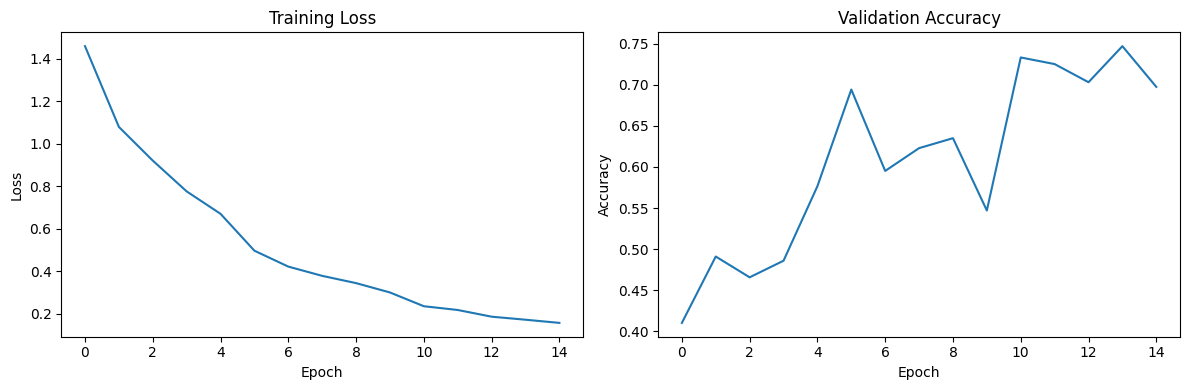

2025-09-26 01:02:51,649 - INFO - Best validation accuracy: 0.7471



=== Final CNN Evaluation ===
Overall Patch Accuracy: 0.8417

Detailed Classification Report:
              precision    recall  f1-score   support

  Canon120-1       0.73      0.57      0.64       880
  Canon120-2       0.50      0.80      0.61      1020
    Canon220       0.65      0.98      0.78      1925
 Canon9000-1       0.97      0.60      0.74      1060
 Canon9000-2       0.79      0.62      0.69      1690
 EpsonV370-1       0.95      0.95      0.95      2550
 EpsonV370-2       0.96      0.96      0.96      3475
  EpsonV39-1       0.91      0.82      0.87      3310
  EpsonV39-2       0.90      0.71      0.79       995
   EpsonV550       0.97      0.89      0.93       875
          HP       1.00      1.00      1.00       785

    accuracy                           0.84     18565
   macro avg       0.85      0.81      0.82     18565
weighted avg       0.87      0.84      0.84     18565



<Figure size 1000x800 with 0 Axes>

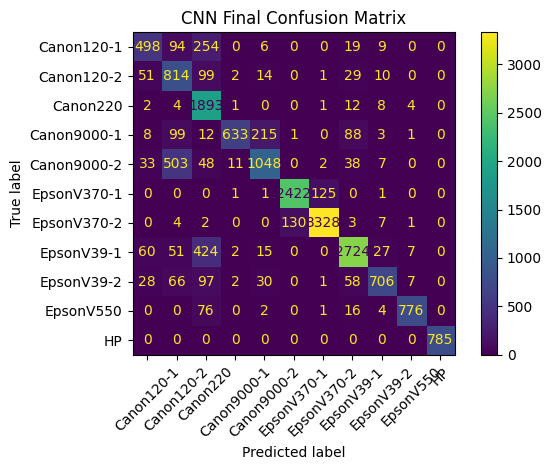

2025-09-26 01:06:15,223 - INFO - Saved SVM to artifacts\svm.joblib
2025-09-26 01:06:15,291 - INFO - Saved Random Forest to artifacts\random_forest.joblib
2025-09-26 01:06:15,378 - INFO - Saved XGBoost to artifacts\xgboost.joblib



Step 6: Saving Models and Results


2025-09-26 01:06:15,588 - INFO - Saved metadata to artifacts\metadata.joblib
2025-09-26 01:06:15,588 - INFO - CNN model saved as best_cnn_model.pt



Pipeline completed successfully!
All artifacts saved in: artifacts/

Summary:
  - Scanner fingerprints: 11 scanners
  - Feature dataset: 493 samples
  - Patch dataset: 18565 patches
  - Trained models: 4


In [4]:
run_complete_pipeline()

In [ ]:
result = predict_document_scanner('path/to/image.jpg', 'artifacts/svm.joblib', 'artifacts/metadata.joblib')


2025-09-04 20:29:24,183 - WARNING - File not found: path/to/image.jpg


In [4]:
results = batch_predict_documents('path/to/images/', 'artifacts/svm.joblib', 'artifacts/metadata.joblib')

2025-09-04 20:29:29,026 - WARNING - Directory does not exist: path/to/images/
